In [48]:
import numpy as np
from pathlib import Path
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os.path
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report



In [49]:
img_dir = Path('/Users/adithyasanthilal/Downloads/archive')

In [51]:
#Getting File Paths,Extracting Labels from File Paths,Converting to Pandas Series,Creating DataFrame
filepaths = list(img_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

#Loop through Unique Categories,Slices Data by Category,Sample 500 Examples from Each Category,Concatenate Sampled DataFrames.
category_examples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_examples.append(category_slice.sample(600, random_state=1))
image_df = pd.concat(category_examples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [52]:
image_df

,Filepath,Label
0,/Users/adithyasanthilal/Downloads/archive/imag...,macarons
1,/Users/adithyasanthilal/Downloads/archive/imag...,ice_cream
2,/Users/adithyasanthilal/Downloads/archive/imag...,cheese_plate
3,/Users/adithyasanthilal/Downloads/archive/imag...,scallops
4,/Users/adithyasanthilal/Downloads/archive/imag...,scallops
...,...,...
60595,/Users/adithyasanthilal/Downloads/archive/imag...,bread_pudding
60596,/Users/adithyasanthilal/Downloads/archive/imag...,takoyaki
60597,/Users/adithyasanthilal/Downloads/archive/imag...,donuts
60598,/Users/adithyasanthilal/Downloads/archive/imag...,gyoza


In [53]:
image_df['Label'].value_counts()

Label
macarons               600
peking_duck            600
grilled_salmon         600
pad_thai               600
gnocchi                600
                      ... 
hummus                 600
breakfast_burrito      600
cheesecake             600
deviled_eggs           600
spaghetti_carbonara    600
Name: count, Length: 101, dtype: int64

In [42]:
image_df['Label'].unique()

array(['macarons', 'ice_cream', 'cheese_plate', 'scallops', 'bibimbap',
       'beef_tartare', 'chocolate_mousse', 'ravioli', 'lobster_bisque',
       'pulled_pork_sandwich', 'gyoza', 'caesar_salad', 'chicken_wings',
       'bruschetta', 'cannoli', 'omelette', 'hot_dog',
       'lobster_roll_sandwich', 'croque_madame', 'caprese_salad',
       'escargots', 'beignets', 'tacos', 'huevos_rancheros',
       'spring_rolls', 'frozen_yogurt', 'cup_cakes', 'red_velvet_cake',
       'deviled_eggs', 'cheesecake', 'breakfast_burrito', 'hummus',
       'garlic_bread', 'churros', 'pho', 'ramen', 'shrimp_and_grits',
       'edamame', 'paella', 'sushi', 'pork_chop', 'donuts', 'carrot_cake',
       'ceviche', 'french_fries', 'miso_soup', 'tiramisu',
       'club_sandwich', 'french_toast', 'foie_gras', 'fried_rice',
       'onion_rings', 'crab_cakes', 'macaroni_and_cheese', 'takoyaki',
       'eggs_benedict', 'chicken_curry', 'hot_and_sour_soup',
       'spaghetti_bolognese', 'baklava', 'falafel', 'panc

In [54]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [55]:
#These generators are commonly used for loading and preprocessing images efficiently during training and testing of deep learning models.
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [56]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 33936 validated image filenames belonging to 101 classes.
Found 8484 validated image filenames belonging to 101 classes.
Found 18180 validated image filenames belonging to 101 classes.


In [57]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 18180 validated image filenames belonging to 101 classes.


In [58]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [59]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(101, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [60]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
1061/1061 [==============================] - 1389s 1s/step - loss: 2.5575 - accuracy: 0.3757 - val_loss: 2.0930 - val_accuracy: 0.4630
Epoch 2/100
1061/1061 [==============================] - 1412s 1s/step - loss: 1.8207 - accuracy: 0.5263 - val_loss: 1.9570 - val_accuracy: 0.4992
Epoch 3/100
1061/1061 [==============================] - 1320s 1s/step - loss: 1.5847 - accuracy: 0.5768 - val_loss: 1.9308 - val_accuracy: 0.5130
Epoch 4/100
1061/1061 [==============================] - 1405s 1s/step - loss: 1.4160 - accuracy: 0.6157 - val_loss: 1.9744 - val_accuracy: 0.5116
Epoch 5/100
1061/1061 [==============================] - 1383s 1s/step - loss: 1.2633 - accuracy: 0.6546 - val_loss: 2.0349 - val_accuracy: 0.5103
Epoch 6/100
1061/1061 [==============================] - 1308s 1s/step - loss: 1.1323 - accuracy: 0.6833 - val_loss: 2.0623 - val_accuracy: 0.5161


In [62]:
import h5py

model.save('Mobilenet_V2_trained_101class.h5')

In [63]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 51.44%


In [64]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

569/569 [==============================] - 561s 985ms/step


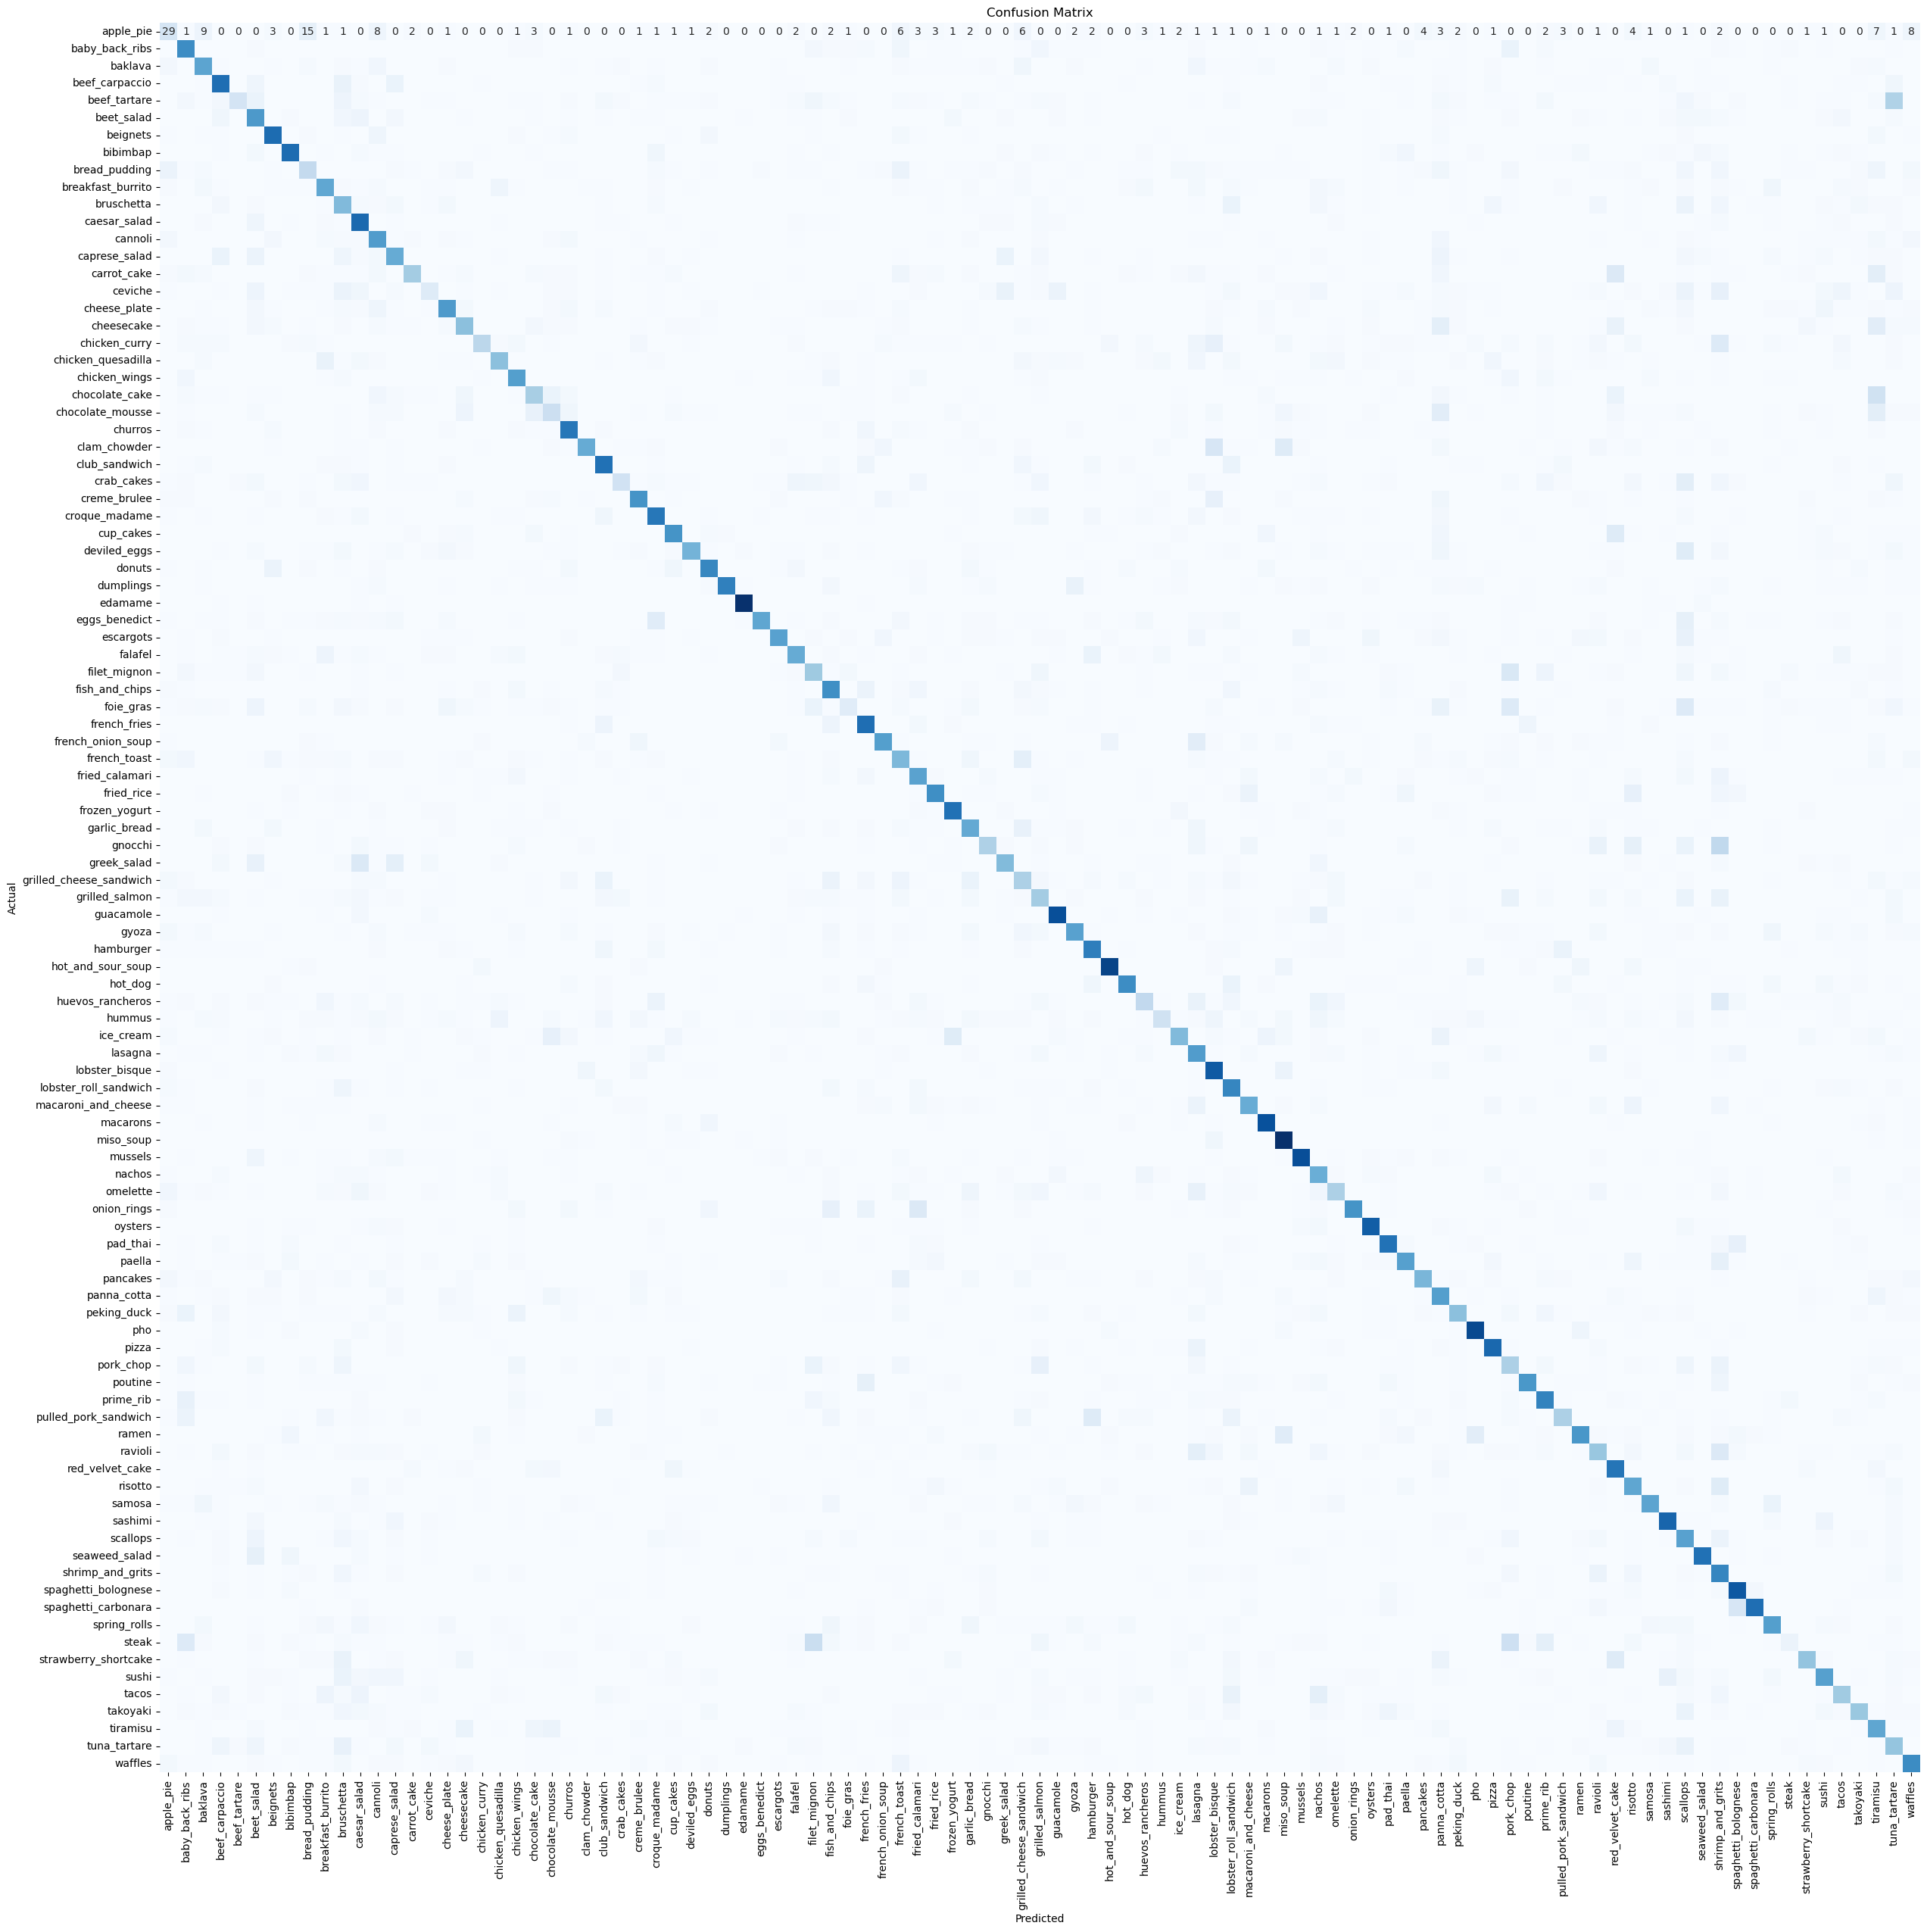

In [65]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [67]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                          precision    recall  f1-score   support

              apple_pie       0.25      0.17      0.21       168
         baby_back_ribs       0.43      0.60      0.51       177
                baklava       0.50      0.52      0.51       174
         beef_carpaccio       0.52      0.64      0.57       200
           beef_tartare       0.75      0.15      0.25       203
             beet_salad       0.33      0.53      0.40       187
               beignets       0.66      0.73      0.69       175
               bibimbap       0.70      0.65      0.67       196
          bread_pudding       0.36      0.26      0.30       166
      breakfast_burrito       0.47      0.49      0.48       183
             bruschetta       0.26      0.44      0.33       172
           caesar_salad       0.42      0.73      0.54       177
                cannoli       0.41      0.60      0.49       163
          caprese_salad       0.40      0.